In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn5 import GRNMain5 as GRNMain
from lib.sde.mutate import mutate_grn5 as mutate_grn, SparseMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time

In [3]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")
_MUTATE_FUNC = SparseMutator()

In [5]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(7, 0, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    for gene in sol.grn.genes:
        gene.noise = max(1, gene.noise)
    sol.grn.compile()
    return sol

In [6]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        _MUTATE_FUNC(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    ref_neuron_supra_early = 0.0
    
    ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron_infra_late = ref_neuron_infra_early
    ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - ref_neuron_infra_late
    
    delta_late = (abs(prog_late - ref_prog_late) + abs(neuron_infra_late - ref_neuron_infra_late)
                  + abs(neuron_supra_late - ref_neuron_supra_late))
    delta_early = (abs(prog_early - ref_prog_early) + abs(neuron_infra_early - ref_neuron_infra_early)
                  + abs(neuron_supra_early - ref_neuron_supra_early))

    return 1 / max(1, 10000 - 1 * delta_late - 0.5 * delta_early)

In [8]:
def get_bb(prun, grn):
    from submodels.grn_bi_v1 import GRNCell
    ccls = factories["grn_bi1"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=50, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [9]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [10]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=10., id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [11]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.steps = example_steps
    return prun

In [12]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [13]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if batch_gen == prun.n_gen:
        print("Already finished")
        return
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // prun.batch_size
            exporter(pop[-prun.batch_size:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [14]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [ ]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "check_simple_obj_r37"
res = main(prun)

Exporting at output/check_simple_obj_r37
[definition] 
    
    
[out] Step 0
[out] ++ Best 9871.074587574589 for generation 0
[out] ++ Best 9871.686832472547 for generation 1
[out] ++ Best 9872.482750839892 for generation 7
Step 3 passed !
[out] ++ Best 9888.819485533772 for generation 10
Saving ...
[out] ++ Best 9892.748056962342 for generation 58
[out] ++ Best 9912.441934513363 for generation 73
[out] ++ Best 9917.155894298752 for generation 78
[out] ++ Best 9928.64569021712 for generation 79
[out] ++ Best 9933.676302462016 for generation 80
Saving ...
[out] Step 100
Saving ...
Saving ...
[out] Step 200
Saving ...
Saving ...
[out] Step 300
Saving ...
Saving ...
[out] Step 400
Saving ...
Saving ...
[out] Step 500
Saving ...
Saving ...
[out] Step 600
Saving ...
[out] ++ Best 9934.951812666099 for generation 670
Saving ...
[out] Step 700
Saving ...
[out] ++ Best 9935.605199819485 for generation 758
Saving ...
[out] Step 800
Saving ...
Saving ...
[out] Step 900
Saving ...
Saving ...
[ou

In [24]:
exp = Exporter(name=prun.name)

Exporting at output/check_simple_obj_r37


In [25]:
sm = read_model("generation")

In [26]:
res = pick_best(exp.load("generation_g10"))

In [27]:
res.fit

9925.921526350097

In [28]:
# for i in range(5):
#     print(fitness_multistep(prun, res.grn, prun.steps))

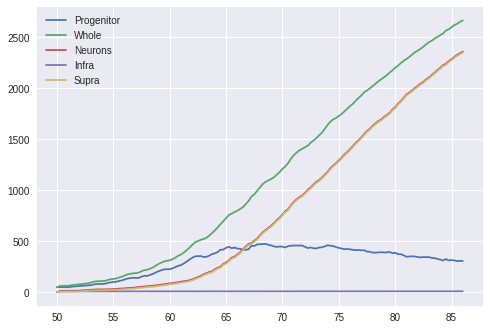

In [29]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(res.stats)

In [ ]:
show_curve(res.stats, REF.stats)

In [30]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} {res.fit} =======")
    print(res.grn)


======= GENERATION generation_g1 9888.819485533772 =======
>> G_0: init: 1.00; noise: 1.00; b: 2.31; m: 2.04; expr: 1.00; deg: 0.10; theta: 7.72; asym: 5.00; tree : ((-5 AND 3) OR (1 AND 0))
>> G_1: init: 0.96; noise: 0.98; b: 2.96; m: 3.95; expr: 1.00; deg: 0.11; theta: 4.48; asym: 5.00; tree : 4
>> G_2: init: 0.64; noise: 1.00; b: 3.90; m: 6.96; expr: 0.99; deg: 0.11; theta: 5.78; asym: 5.00; tree : -2
>> G_3: init: 1.57; noise: 1.00; b: 0.44; m: 1.61; expr: 1.00; deg: 0.10; theta: 4.24; asym: 5.00; tree : -7
>> G_4: init: 1.41; noise: 1.00; b: 2.47; m: 3.69; expr: 1.00; deg: 0.10; theta: 2.35; asym: 5.75; tree : ((-2 OR 4) AND (-5 OR -6))
>> G_5: init: 1.53; noise: 1.00; b: 3.07; m: 2.09; expr: 1.00; deg: 0.10; theta: 3.62; asym: 5.00; tree : (-2 OR (-1 AND 4))
>> G_6: init: 0.85; noise: 1.00; b: 3.90; m: 2.35; expr: 1.00; deg: 0.10; theta: 1.21; asym: 5.00; tree : -7

======= GENERATION generation_g2 9933.676302462016 =======
>> G_0: init: 1.00; noise: 1.06; b: 2.31; m: 2.05; expr